# Ischemic heart disease in Men vs Women
At what age is ischemic heart disease first discovered for men vs women.
Below we have used a synthetic dataset of patient data with 28491 women and 28116 men.

In [257]:
import random
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""

df = pd.read_sql(query, conn)

## The actual distributions
Below the distributions of the ages, where the disease is discovered for men and women, is graphed.

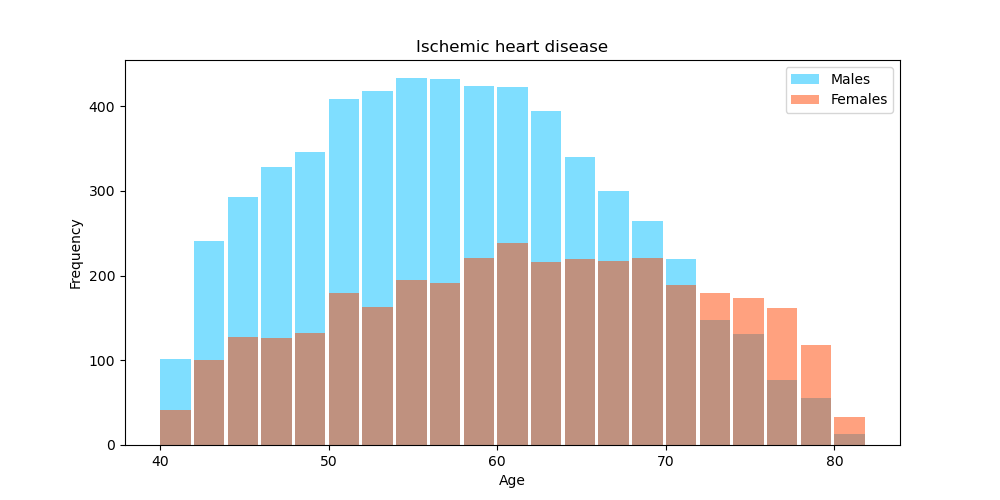

In [258]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.rcParams['figure.figsize'] = [10, 5] #size

wdf = df.where(df.gender == "F").dropna().groupby(['age', 'gender']).count().reset_index()
mdf = df.where(df.gender == "M").dropna().groupby(['age', 'gender']).count().reset_index()
xwomen = wdf["age"]
ywomen = wdf["patient"]
xmen = mdf["age"]
ymen = mdf["patient"]

plt.cla()
plt.bar(xmen, ymen, width=1.8, align='edge', label='Males', alpha=0.5, color='deepskyblue')
plt.bar(xwomen, ywomen, width=1.8, align='edge', label='Females', alpha=0.5, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

Mens distribution peaks earlier than the womens and there seem to be more cases for men. Around age 55 for men and 62 for women. These are properties we would like to persist after differential privacy is applied.

## With DP
Below we use openDP to apply noise to the queries.

In [259]:
delta = 0.001 #TODO: is this the way?

In [260]:
import snsql
from snsql import Privacy

metadata = {
    '':{
        '': {
            'MyTable': {
                'max_ids': 1,
                'row_privacy': True,
                'patient': {
                    'name': 'patient',
                    'type': 'string'
                },
                'age': {
                    'name': 'age',
                    'type': 'int',
                    'lower': '0',
                    'upper': '100'
                },
                'gender': {
                    'name': 'gender',
                    'type': 'string'
                }
            }
        }
    }
}

privacy = Privacy(epsilon=0.1, delta=0.001)
reader = snsql.from_connection(df, privacy=privacy, metadata=metadata)

/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning:

Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.



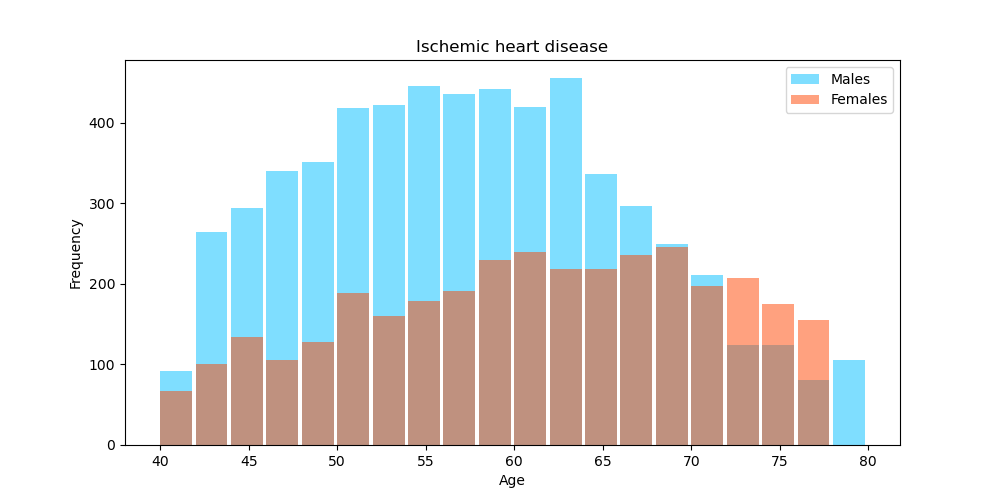

In [261]:
dpdata = reader.execute('SELECT gender, age, COUNT(patient) as amount FROM MyTable GROUP BY gender, age')[1:]

plt.cla()
plt.bar(list(map(lambda t: t[1], dpdata[19:])), list(map(lambda t: t[2], dpdata[19:])), width=1.8, align='edge', label='Males', alpha=0.5, color='deepskyblue')
plt.bar(list(map(lambda t: t[1], dpdata[:19])), list(map(lambda t: t[2], dpdata[:19])), width=1.8, align='edge', label='Females', alpha=0.5, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

In [262]:
dpdata

[['F', 40, 67],
 ['F', 42, 100],
 ['F', 44, 134],
 ['F', 46, 106],
 ['F', 48, 128],
 ['F', 50, 189],
 ['F', 52, 160],
 ['F', 54, 179],
 ['F', 56, 191],
 ['F', 58, 230],
 ['F', 60, 240],
 ['F', 62, 219],
 ['F', 64, 219],
 ['F', 66, 236],
 ['F', 68, 246],
 ['F', 70, 197],
 ['F', 72, 207],
 ['F', 74, 175],
 ['F', 76, 155],
 ['F', 78, 106],
 ['M', 40, 92],
 ['M', 42, 264],
 ['M', 44, 294],
 ['M', 46, 340],
 ['M', 48, 351],
 ['M', 50, 418],
 ['M', 52, 422],
 ['M', 54, 446],
 ['M', 56, 436],
 ['M', 58, 442],
 ['M', 60, 419],
 ['M', 62, 455],
 ['M', 64, 336],
 ['M', 66, 296],
 ['M', 68, 249],
 ['M', 70, 211],
 ['M', 72, 124],
 ['M', 74, 124],
 ['M', 76, 81]]

We run the dp mechanism 1000 times and find the min and max frequencies for all ages which we then plot.

In [263]:
wValues = {}
mValues = {}
wMeans = []
mMeans = []
for i in range(100):
    r = reader.execute('SELECT gender, age, COUNT(patient) as amount FROM MyTable GROUP BY gender, age')[1:]
    wSum = 0
    wMean = 0
    mSum = 0
    mMean = 0
    #calculate mean for women and men
    for j, e in enumerate(r):
        a = e[1]
        v = e[2]
        if e[0] == 'F':
            wSum = wSum + v
            wMean = wMean + (a * v)
        else:
            mSum = mSum + v
            mMean = mMean + (a * v)
    wMeans.append(wMean / wSum)
    mMeans.append(mMean / mSum)
    for e in r:
        if e[0] == 'M':
            k = e[1]
            v = e[2]
            if not k in mValues:
                mValues[k] = []
            mValues[k].append(v)
        else:
            k = e[1]
            v = e[2]
            if not k in wValues:
                wValues[k] = []
            wValues[k].append(v)

In [264]:
wMeans2 = []
mMeans2 = []
for i in range(10000):
    r = reader.execute('SELECT gender, AVG(age) as age FROM MyTable GROUP BY gender')[1:]
    wMeans2.append(r[0][1])
    mMeans2.append(r[1][1])


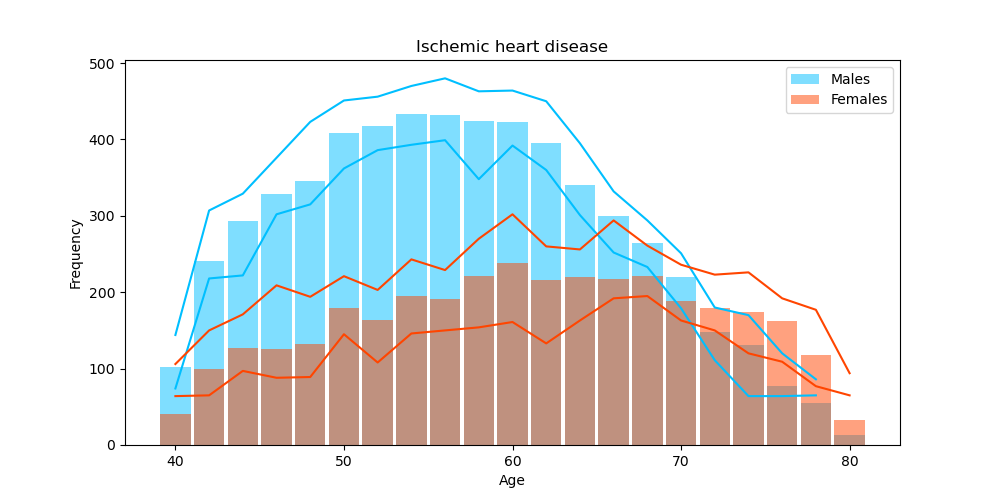

In [265]:
mXs = []
mMinvalues = []
mMaxvalues = []
for x in mValues:
    mXs.append(x)
    mMinvalues.append(min(mValues[x]))
    mMaxvalues.append(max(mValues[x]))
wXs = []
wMinvalues = []
wMaxvalues = []
for x in wValues:
    wXs.append(x)
    wMinvalues.append(min(wValues[x]))
    wMaxvalues.append(max(wValues[x]))

# stupid sorting
mMinvalues = [x for _, x in sorted(zip(mXs, mMinvalues))]
mMaxvalues = [x for _, x in sorted(zip(mXs, mMaxvalues))]
mXs = sorted(mXs)

wMinvalues = [x for _, x in sorted(zip(wXs, wMinvalues))]
wMaxvalues = [x for _, x in sorted(zip(wXs, wMaxvalues))]
wXs = sorted(wXs)

plt.cla()
plt.bar(xmen, ymen, width=1.8, align='center', label='Males', alpha=0.5, color='deepskyblue')
plt.bar(xwomen, ywomen, width=1.8, align='center', label='Females', alpha=0.5, color='orangered')
plt.plot(mXs, mMaxvalues, color='deepskyblue')
plt.plot(mXs, mMinvalues, color='deepskyblue')
plt.plot(wXs, wMaxvalues, color='orangered')
plt.plot(wXs, wMinvalues, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

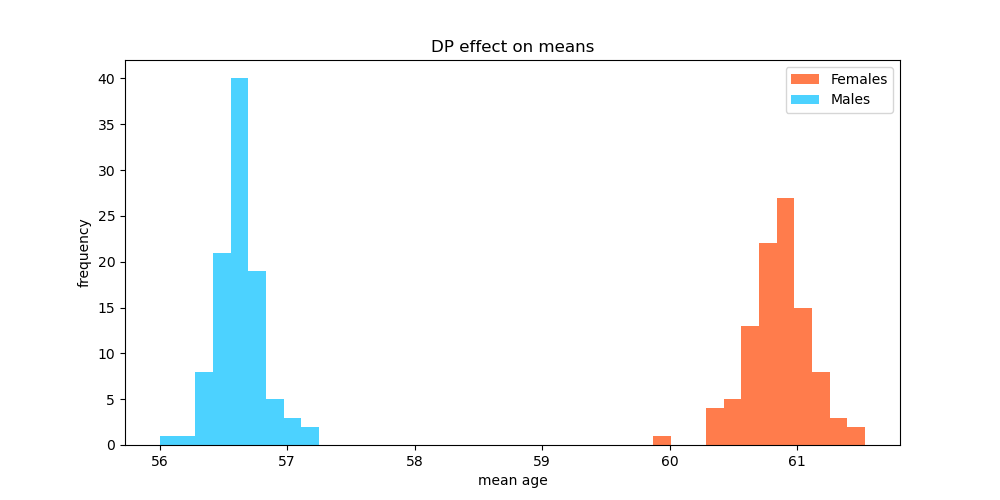

In [266]:
import numpy as np

plt.cla()
bins=np.histogram(np.hstack((wMeans,mMeans)), bins=40)[1]
plt.hist(wMeans, bins, color='orangered', label='Females', alpha=0.7)
plt.hist(mMeans, bins, color='deepskyblue', label='Males', alpha=0.7)
plt.xlabel('mean age')
plt.ylabel('frequency')
plt.title('DP effect on means')
plt.legend()
plt.show()

Here we query the means directly instead of calculating them from the counts

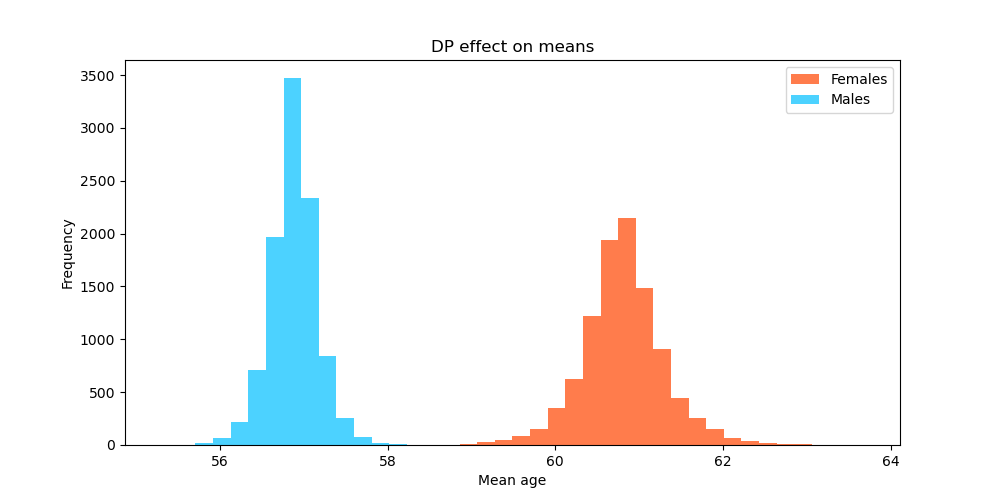

In [267]:
plt.cla()
bins=np.histogram(np.hstack((wMeans2,mMeans2)), bins=40)[1]
plt.hist(wMeans2, bins, color='orangered', label='Females', alpha=0.7)
plt.hist(mMeans2, bins, color='deepskyblue', label='Males', alpha=0.7)
plt.xlabel('Mean age')
plt.ylabel('Frequency')
plt.title('DP effect on means')
plt.legend()
plt.show()

An interpretation could be something like "~5% chance of mens avg to be 58 and ~5% chance of womens avg to be 59, that is 5% * 5% = 0.25% chance of the means to be within 1 year range, which would be a problem because a medical expert might not find the difference significant"

In [268]:
import pingouin as pg
pg.compute_effsize(wMeans2, mMeans2, paired=False, eftype='cohen')

9.879967706887298

In [269]:
def customMetric(maleMeans, femaleMeans, minDistance):
    maleLoc, maleScale = laplace.fit(maleMeans)
    femaleLoc, femaleScale = laplace.fit(femaleMeans)
    maleDist = laplace(loc=maleLoc, scale=maleScale)
    femaleDist = laplace(loc=femaleLoc, scale=femaleScale)
    count = 0
    for i in range(10000):
        maleAge = maleDist.rvs(size=1)
        femaleAge = femaleDist.rvs(size=1)
        if femaleAge[0] - maleAge[0] < minDistance:
            count = count + 1
    return count / 10000

In [270]:
import random
#Monte carlo
def customMetric2(maleMeans, femaleMeans, minDistance):
    count = 0
    for i in range(10000):
        maleAge = random.choice(maleMeans)
        femaleAge = random.choice(femaleMeans)
        if femaleAge - maleAge < minDistance:
            count = count + 1
    return count / 10000

In [271]:
from scipy.stats import norm
def customMetric3(maleMeans, femaleMeans, minDistance):
    mu1 = np.mean(maleMeans)
    var1 = np.var(maleMeans, ddof=1)
    mu2 = np.mean(femaleMeans)
    var2 = np.var(femaleMeans, ddof=1)

    std_dev = (var1 + var2) ** 0.5
    z_score = (minDistance - (mu1 - mu2)) / std_dev

    return 1 - norm.cdf(z_score)

In [272]:
print(customMetric2(mMeans2, wMeans2, 1))

0.0001


# Experimenting with epsilon
With epsilon 0.1 there does not seem to be a big problem in the range the mean will land in. But to make the output as private as possible we want to decrease the epsilon to as little as possible. Below we experiment with how epsilon affects this distribution of the mean when the DP mechanism is run multiple times.

In [273]:
def means(eps, times):
    privacy_ = Privacy(epsilon=eps, delta=delta)
    reader_ = snsql.from_connection(df, privacy=privacy_, metadata=metadata)
    means_ = pd.DataFrame(columns=['F', 'M'])
    for i in range(times):
        result_ = reader_.execute('SELECT gender, AVG(age) as age FROM MyTable GROUP BY gender')
        means_ = pd.concat([means_, pd.DataFrame([result_[1], result_[2]], columns=result_[0]).pivot_table(columns=['F', 'M'])])
    return means_

In [274]:
meansByEpsilon = {}
for i in range(20):
    eps = round(0.1 - (0.005 * i), 3)
    meansByEpsilon[eps] = means(eps, 100)

/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning:

Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.

/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning:

Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals

Text(0.5, 0.92, 'Epsilon effect on mean')

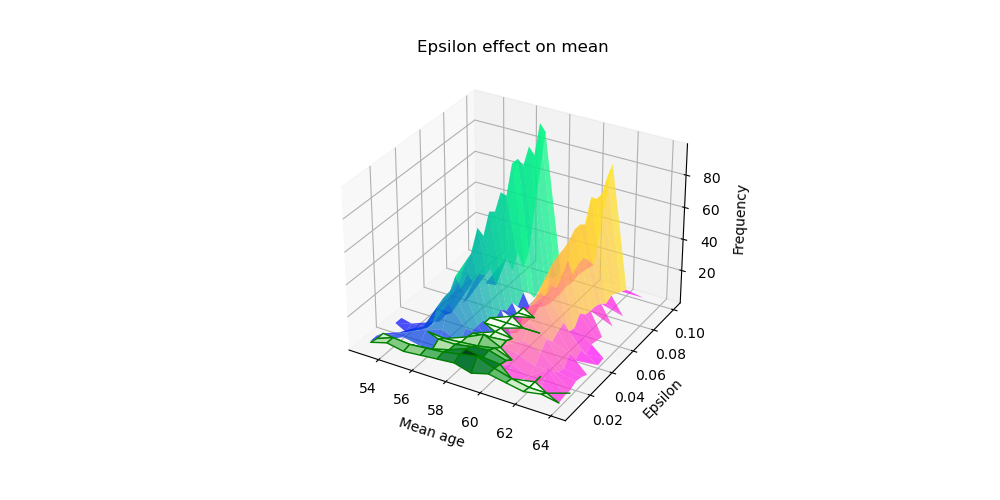

In [275]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = [10, 5] #size

# function for z axis
def fw(x, y):
    y = round(y, 3)
    r = meansByEpsilon[y]['F'].where(round(meansByEpsilon[y].F) == x).count()
    return r if r > 0 else np.nan

def fm(x, y):
    y = round(y, 3)
    r = meansByEpsilon[y]['M'].where(round(meansByEpsilon[y].M) == x).count()
    return r if r > 0 else np.nan

# x and y axis
x = np.linspace(53, 64, 12) #age
y = np.linspace(0.1, 0.005, 20) #espilon
X, Y = np.meshgrid(x, y)

# women
Zw = np.zeros([20, 12])
for i in range(20):
    for j in range(12):
        Zw[i][j] = fw(X[i][j], Y[i][j])

# men
Zm = np.zeros([20, 12])
for i in range(20):
    for j in range(12):
        Zm[i][j] = fm(X[i][j], Y[i][j])

# intersection
Zi = np.zeros([20, 12])
for i in range(20):
    for j in range(12):
        w_ = Zw[i][j]
        m_ = Zm[i][j]
        if w_ > 0 and m_ > 0:
            Zi[i][j] = min(w_, m_)
        else:
            Zi[i][j] = np.nan

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(X, Y, Zm, cmap ='winter', alpha=0.7, label='Males')
ax.plot_surface(X, Y, Zw, cmap ='spring', alpha=0.7, label='Females')
ax.plot_surface(X, Y, Zi, cmap ='Greens', alpha=1, label='intersection', edgecolors='g')
ax.set_ylabel('Epsilon')
ax.set_xlabel('Mean age')
ax.set_zlabel('Frequency')
ax.set_title('Epsilon effect on mean')
# ax.legend()

We can tell that with a low enough epsilon the distributions merges and the mens mean vs the womens mean might become to close, or indistinguishable. But can we somehow decide on a metric that decides when epsilon is too low? Let's plot how much area of the distributions overlap.

In [276]:
from scipy.stats import gaussian_kde
from scipy.integrate import trapz

xs = []
os = []
for k in meansByEpsilon:
    f = meansByEpsilon[k]["F"]
    m = meansByEpsilon[k]["M"]
    kde1 = gaussian_kde(f)
    kde2 = gaussian_kde(m)
    x_min = min(min(f), min(m))
    x_max = max(max(f), max(m))
    x = np.linspace(x_min, x_max, 1000)
    y1 = kde1(x)
    y2 = kde2(x)
    overlap = trapz(np.minimum(y1, y2), x)
    xs.append(k)
    os.append(overlap)

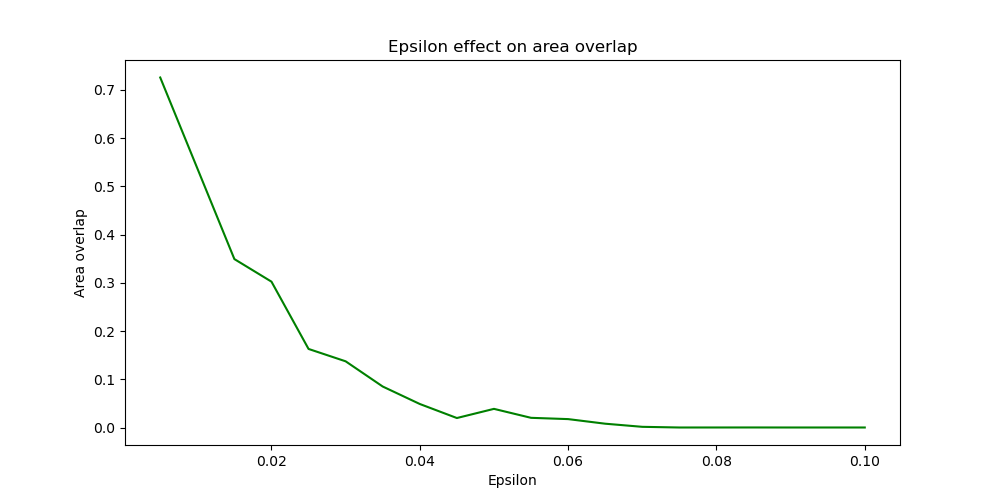

In [277]:
fig, ax = plt.subplots()
plt.plot(xs, os, color="g")
plt.xlabel('Epsilon')
plt.ylabel('Area overlap')
plt.title('Epsilon effect on area overlap')
plt.show()

Is this a sufficient metric? Let's use Cohen's D to compare the effect size between the two distributions.

In [278]:
import pingouin as pg
xs = []
ys = []
for k in meansByEpsilon:
    f = meansByEpsilon[k]["F"]
    m = meansByEpsilon[k]["M"]
    d = pg.compute_effsize(f, m, paired=False, eftype='cohen')
    xs.append(k)
    ys.append(d)

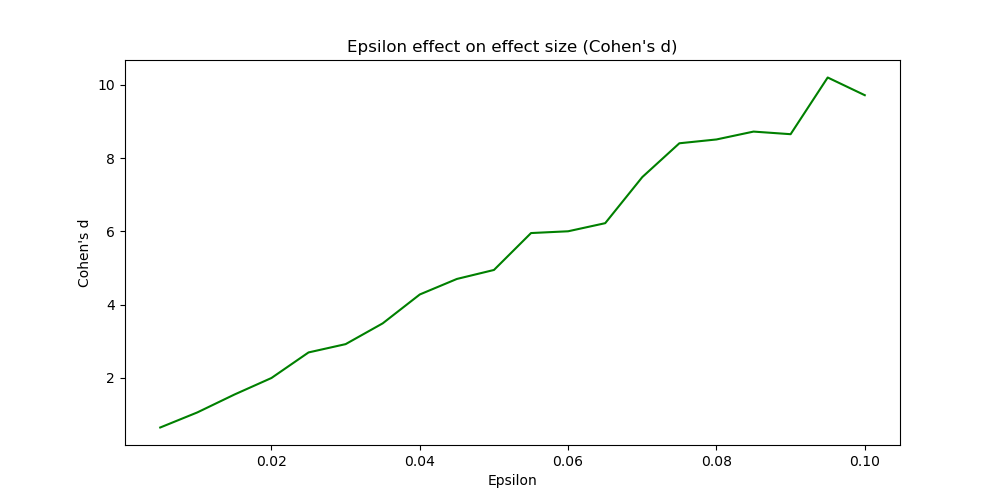

In [279]:
fig, ax = plt.subplots()
plt.plot(xs, ys, color="g")
plt.xlabel('Epsilon')
plt.ylabel("Cohen's d")
plt.title("Epsilon effect on effect size (Cohen's d)")
plt.show()

In [283]:
xs = []
ys = []
for k in meansByEpsilon:
    f = meansByEpsilon[k]["F"]
    m = meansByEpsilon[k]["M"]
    d = customMetric2(m, f, 1)
    xs.append(k)
    ys.append(d)
    if d > 0.005:
        print(k)

0.055
0.05
0.045
0.04
0.035
0.03
0.025
0.02
0.015
0.01
0.005


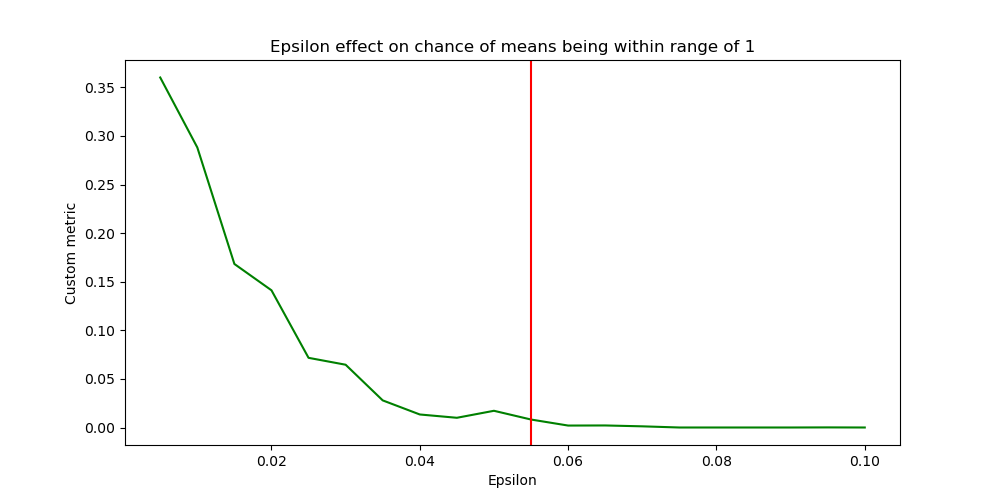

In [285]:
fig, ax = plt.subplots()
plt.plot(xs, ys, color="g")
plt.xlabel('Epsilon')
plt.ylabel("Custom metric")
plt.title("Epsilon effect on chance of means being within range of 1")
plt.axvline(x = 0.055, color = 'r')
plt.show()

We can see that cohen's d decreases with epsilon but how can we decide upon a value of cohen's d which is too low?

# More things we could expand with
- Do it all with different data
- Do it all but with gaussian noise instead of laplace
- 3d plot but with sample size instead of epsilon
- Randomized response with self harm
- Something with score2